In [21]:
import pandas as pd
import matplotlib.pyplot as plt
import requests
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
import warnings
warnings.filterwarnings("ignore")

In [22]:

url = "https://web-api.coinmarketcap.com/v1/cryptocurrency/ohlcv/historical"
param = {"convert":"USD","slug":"bitcoin","time_end":"1601410800","time_start":"1467101200"}
content = requests.get(url=url, params=param).json()
df = pd.json_normalize(content['data']['quotes'])

In [23]:
df['Date']=pd.to_datetime(df['quote.USD.timestamp']).dt.tz_localize(None)
df['Low'] = df['quote.USD.low']
df['High'] = df['quote.USD.high']
df['Open'] = df['quote.USD.open']
df['Close'] = df['quote.USD.close']
df['Volume'] = df['quote.USD.volume']

In [24]:
df=df.drop(columns=['time_open','time_close','time_high','time_low', 'quote.USD.low', 'quote.USD.high', 'quote.USD.open', 'quote.USD.close', 'quote.USD.volume', 'quote.USD.market_cap', 'quote.USD.timestamp'])


In [25]:
df['Mean'] = (df['Low'] + df['High'])/2

In [26]:
df = df.dropna()

In [27]:
dataset_for_prediction = df.copy()
dataset_for_prediction['Actual']=dataset_for_prediction['Mean'].shift()
dataset_for_prediction=dataset_for_prediction.dropna()


In [28]:
dataset_for_prediction['Date'] =pd.to_datetime(dataset_for_prediction['Date'])
dataset_for_prediction.index= dataset_for_prediction['Date']

In [29]:
from sklearn.preprocessing import MinMaxScaler
sc_in = MinMaxScaler(feature_range=(0, 1))
scaled_input = sc_in.fit_transform(dataset_for_prediction[['Low', 'High', 'Open', 'Close', 'Volume', 'Mean']])
scaled_input = pd.DataFrame(scaled_input, index=dataset_for_prediction.index)
X=scaled_input
X.rename(columns={0:'Low', 1:'High', 2:'Open', 3:'Close', 4:'Volume', 5:'Mean'}, inplace=True)
print("Normalized X")
print(X.head())

Normalized X
                              Low      High      Open     Close    Volume  \
Date                                                                        
2016-06-30 23:59:59.999  0.005708  0.005229  0.004857  0.006642  0.001417   
2016-07-01 23:59:59.999  0.007497  0.005780  0.006544  0.006798  0.001355   
2016-07-02 23:59:59.999  0.007866  0.006679  0.006767  0.008245  0.001057   
2016-07-03 23:59:59.999  0.006381  0.006744  0.008259  0.005868  0.001289   
2016-07-04 23:59:59.999  0.006462  0.005652  0.005820  0.007187  0.000783   

                             Mean  
Date                               
2016-06-30 23:59:59.999  0.005194  
2016-07-01 23:59:59.999  0.006347  
2016-07-02 23:59:59.999  0.006988  
2016-07-03 23:59:59.999  0.006300  
2016-07-04 23:59:59.999  0.005778  


In [30]:
sc_out = MinMaxScaler(feature_range=(0, 1))
scaler_output = sc_out.fit_transform(dataset_for_prediction[['Actual']])
scaler_output =pd.DataFrame(scaler_output, index=dataset_for_prediction.index)
y=scaler_output
y.rename(columns={0:'BTC Price next day'}, inplace= True)
y.index=dataset_for_prediction.index
print("Normalized y")
print(y.head())

Normalized y
                         BTC Price next day
Date                                       
2016-06-30 23:59:59.999            0.004165
2016-07-01 23:59:59.999            0.005194
2016-07-02 23:59:59.999            0.006347
2016-07-03 23:59:59.999            0.006988
2016-07-04 23:59:59.999            0.006300


In [31]:
train_size=int(len(df) *0.9)
test_size = int(len(df)) - train_size
train_X, train_y = X[:train_size].dropna(), y[:train_size].dropna()
test_X, test_y = X[train_size:].dropna(), y[train_size:].dropna()

In [32]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

model = SARIMAX(endog=train_y, exog=train_X, order=(0, 1, 1))


In [33]:

results = model.fit()

In [34]:

predictions = results.predict(start =train_size, end=train_size+test_size-2,exog=test_X)

In [35]:

act = pd.DataFrame(scaler_output.iloc[train_size:, 0])
predictions=pd.DataFrame(predictions)
predictions.reset_index(drop=True, inplace=True)
predictions.index=test_X.index
predictions['Actual'] = act['BTC Price next day']
predictions.rename(columns={0:'Pred', 'predicted_mean':'Pred'}, inplace=True)

In [36]:
testPredict = sc_out.inverse_transform(predictions[['Pred']])
testActual = sc_out.inverse_transform(predictions[['Actual']])

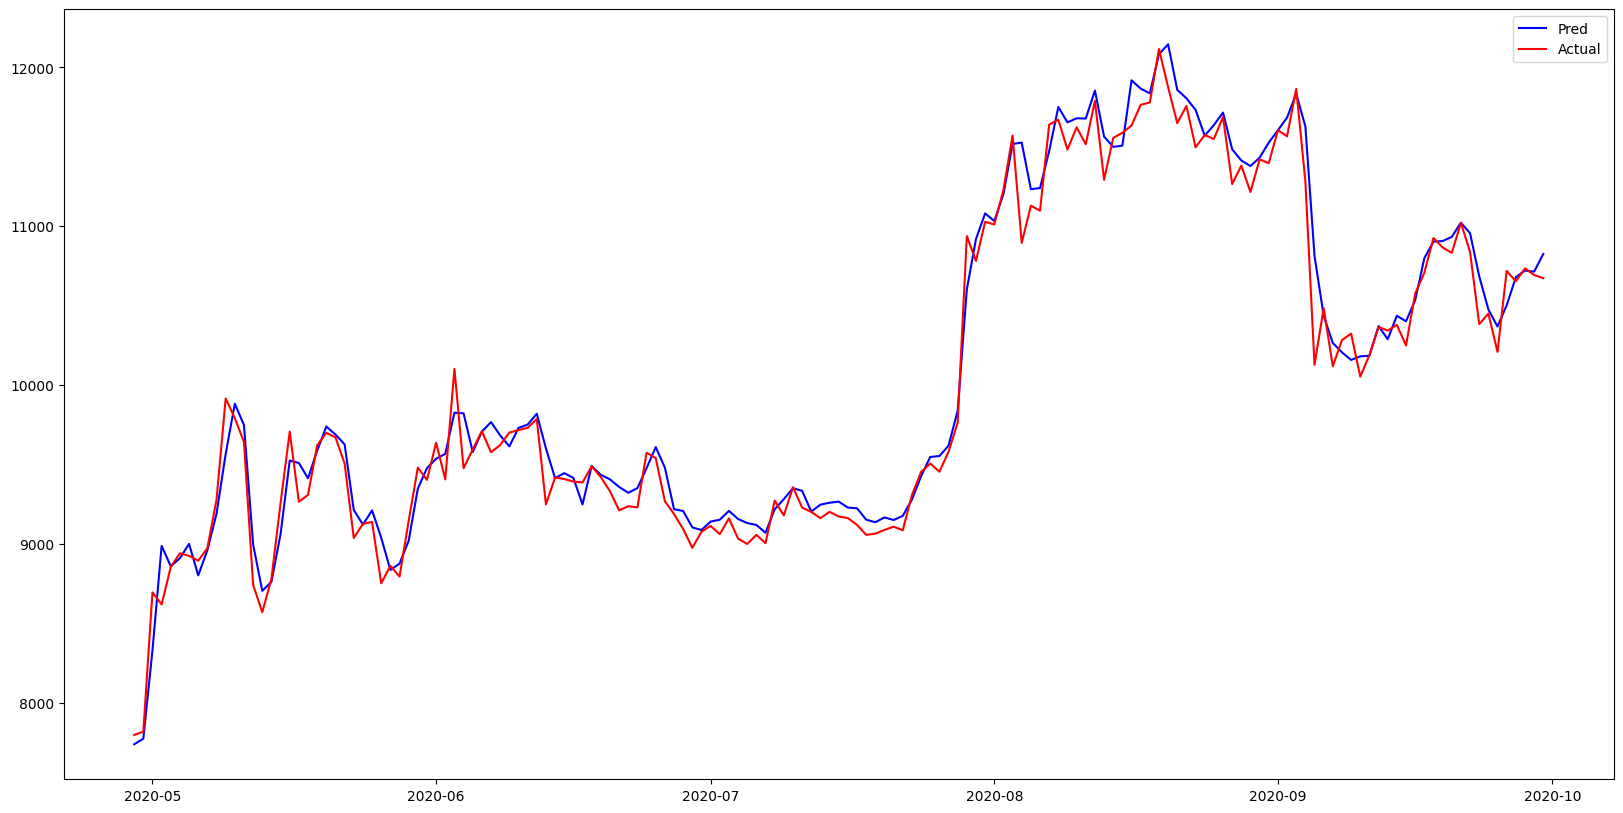

In [37]:
plt.figure(figsize=(20,10))
plt.plot(predictions.index, testActual, label='Pred', color='blue')
plt.plot(predictions.index, testPredict, label='Actual', color='red')
plt.legend()
plt.show()


In [38]:
from statsmodels.tools.eval_measures import rmse
print("RMSE:",rmse(testActual, testPredict))

RMSE: [153.01123531]
